In [34]:
'''
Analyze.py
Takes a ticker symbol and displays:
 - Regression targets based on most recent p-e
 - Regression targets based on most recent yield, if applicable
 - Plots return distribution for similar historic p-e
 - Plots retrun distribution for similar historic yield, if applicable
'''

import pandas as pd
import sqlite3
import datetime
from datetime import date
import numpy as np
import matplotlib
import sys
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import KFold

import importlib

importlib.import_module('market_df')
from market_df import *

from matplotlib import pyplot as plt
#plt.figure(figsize=(20,10))
%matplotlib inline

In [35]:


kern_200 = [0.000001,0.000001,0.000001,0.000001,0.000001,0.000002,0.000002,0.000002,0.000003,0.000003,0.000004,0.000005,0.000006,0.000007,0.000009,0.00001,0.000012,0.000015,0.000017,0.000021,0.000024,0.000029,0.000034,0.00004,0.000047,0.000054,0.000063,0.000074,0.000086,0.000099,0.000115,0.000133,0.000153,0.000176,0.000202,0.000231,0.000264,0.000301,0.000342,0.000388,0.00044,0.000498,0.000562,0.000632,0.000711,0.000797,0.000892,0.000996,0.00111,0.001235,0.001371,0.001519,0.001679,0.001852,0.002038,0.002239,0.002455,0.002686,0.002932,0.003194,0.003473,0.003769,0.00408,0.004409,0.004754,0.005116,0.005494,0.005888,0.006297,0.00672,0.007157,0.007607,0.008068,0.00854,0.00902,0.009508,0.010002,0.010499,0.010999,0.011498,0.011996,0.012489,0.012975,0.013453,0.013919,0.014372,0.014809,0.015228,0.015626,0.016002,0.016353,0.016677,0.016972,0.017237,0.01747,0.01767,0.017835,0.017964,0.018058,0.018114,0.018132,0.018114,0.018058,0.017964,0.017835,0.01767,0.01747,0.017237,0.016972,0.016677,0.016353,0.016002,0.015626,0.015228,0.014809,0.014372,0.013919,0.013453,0.012975,0.012489,0.011996,0.011498,0.010999,0.010499,0.010002,0.009508,0.00902,0.00854,0.008068,0.007607,0.007157,0.00672,0.006297,0.005888,0.005494,0.005116,0.004754,0.004409,0.00408,0.003769,0.003473,0.003194,0.002932,0.002686,0.002455,0.002239,0.002038,0.001852,0.001679,0.001519,0.001371,0.001235,0.00111,0.000996,0.000892,0.000797,0.000711,0.000632,0.000562,0.000498,0.00044,0.000388,0.000342,0.000301,0.000264,0.000231,0.000202,0.000176,0.000153,0.000133,0.000115,0.000099,0.000086,0.000074,0.000063,0.000054,0.000047,0.00004,0.000034,0.000029,0.000024,0.000021,0.000017,0.000015,0.000012,0.00001,0.000009,0.000007,0.000006,0.000005,0.000004,0.000003,0.000003,0.000002,0.000002,0.000002,0.000001,0.000001,0.000001,0.000001,0.000001]
kern_50 =  [0,0.000001,0.000002,0.000005,0.000012,0.000027,0.00006,0.000125,0.000251,0.000484,0.000898,0.001601,0.002743,0.004514,0.00714,0.010852,0.015849,0.022242,0.029993,0.038866,0.048394,0.057904,0.066574,0.073551,0.078084,0.079656,0.078084,0.073551,0.066574,0.057904,0.048394,0.038866,0.029993,0.022242,0.015849,0.010852,0.00714,0.004514,0.002743,0.001601,0.000898,0.000484,0.000251,0.000125,0.00006,0.000027,0.000012,0.000005,0.000002,0.000001,0]

reits = ['CHP.UN', 'AP.UN' , 'AX.UN', 'BEI.UN', 'CAR.UN', 'CRR.UN', 'CUF.UN', 'D.UN', 'DRG.UN', 'EXE', 'GRT.UN', 'HR.UN', 'IIP.UN', 'KMP.UN', 'NVU.UN', 'REI.UN', 'SRU.UN']

yahoo_db = '/home/ian/Data/yahoo.db'
tmx_db = '/home/ian/Data/tmx.db'
advfn_db = '/home/ian/Data/advfn.db'

#outfile = open("prediction_report.txt","w") 

yahoo_database = sqlite3.connect(yahoo_db)
tmx_database = sqlite3.connect(tmx_db)
advfn_database = sqlite3.connect(advfn_db)
advfn_curs = advfn_database.cursor()



In [36]:
def process_row(symbol, row, df):
    if (row['close'] != row['close']) | (row['close'] == 'null'):
        df.at[row['date_parsed'], 'pe'] = np.NaN
        df.at[row['date_parsed'], 'dy'] = np.NaN
        return
    if row['eps'] == row['eps']:
        if row['eps'] == 0:
            df.at[row['date_parsed'], 'pe'] = np.NaN
        else:
            df.at[row['date_parsed'], 'pe'] = float(row['close']) / (4*row['eps'])
    
    if row['eps'] == row['eps']:
        if row['close'] == 0:
            df.at[row['date_parsed'], 'dy'] = np.NaN
        elif symbol in reits: #reits pay monthly
            df.at[row['date_parsed'], 'dy'] = 12* row['div'] / (float(row['close']) * row['split_adj'])
        else:
            df.at[row['date_parsed'], 'dy'] = 4* row['div'] / (float(row['close']) * row['split_adj'])

In [37]:
def custom_kernel(func, kern):
    '''
    Convolution of a function by a kernel.
    Kernel must be odd in length
    Function must be longer than kernel    
    '''
    if len(func) <= len(kern):
        return func
    else:
        #midpoint of the kernel
        mid_kern = int((len(kern) + 1)/2)
        
    conv_func = np.zeros(len(func))
    
    for index, value in enumerate(func):

        if index < mid_kern:
            #go from kern[mid_kern] to end for zero
            dist_from_start = index -1
            kern_start = mid_kern - dist_from_start         
           
            sum = 0.0
            area = 0.0
            for i in range(kern_start, len(kern)):                
                sum += kern[i] * func[index + i - mid_kern]
                #need to correct for the area under the partial kernel being < 1
                area += kern[i]
            conv_func[index] = sum / area
            
        elif index > len(func) - mid_kern:         
            #go from zero to mid_kern + (distance to end of func)
            dist_to_end = len(func) - index + 1
            sum = 0.0
            area = 0.0
            for i in range(0, (mid_kern + dist_to_end -1)):
                sum += kern[i] * func[index + i - mid_kern]
                area += kern[i]
            conv_func[index] = sum / area   
            
        else:
            #sum of kernel * function over window of kernel length centered on func[index]
            sum = 0.0
            for kern_ind, kern_val in enumerate(kern):
                sum += kern_val * func[index + kern_ind - mid_kern]

            conv_func[index] = sum
        
    return conv_func

In [38]:
def return_to_date(row, today, last_close):
    elapsed_years = (today - row['date']).days / 365.25
    if elapsed_years == 0:
        return 1.0
    gain = last_close / row['close']
    ann_gain = gain ** (1/elapsed_years)
    return 100 * (ann_gain - 1.0)

In [39]:
def prune_data(df, divs, num_sig):
    '''
    Removes outliers from the dataframe
    Removes num_sig-sigma
    '''

    if divs:
        pe_mean = np.mean(df['pe'])
        pe_std = np.std(df['pe'])
        div_mean = np.mean(df['dy'])
        div_std = np.std(df['dy'])
        gain_mean = np.mean(df['tot_gain'])
        gain_std = np.std(df['tot_gain'])
        pe_upper = pe_mean + num_sig * pe_std
        pe_lower = pe_mean - num_sig * pe_std
        div_upper = div_mean + num_sig * div_std
        div_lower = div_mean - num_sig * div_std
        gain_upper = gain_mean + num_sig * gain_std
        gain_lower = gain_mean - num_sig * gain_std

        df_pruned = df[(df['pe'] < pe_upper) & (df['pe'] > pe_lower) & (df['dy'] < div_upper) & (df['dy'] > div_lower) & (df['pe'] > 0) & (df['tot_gain'] < gain_upper) & (df['tot_gain'] > gain_lower)].copy()
 
    else:
        pe_mean = np.mean(df['pe'])
        pe_std = np.std(df['pe'])

        pe_upper = pe_mean + num_sig * pe_std
        pe_lower = pe_mean - num_sig * pe_std
        
        gain_mean = np.mean(df['tot_gain'])
        gain_std = np.std(df['tot_gain'])
        
        gain_upper = gain_mean + num_sig * gain_std
        gain_lower = gain_mean - num_sig * gain_std

        df_pruned = df[(df['pe'] < pe_upper) & (df['pe'] > pe_lower) & (df['pe'] > 0) & (df['tot_gain'] < gain_upper) & (df['tot_gain'] > gain_lower)].copy()

    return df_pruned


In [40]:
def get_todays_metrics(df, divs):
    if divs:
        dy = df['dy'][df.shape[0] -1]
    else:
        dy = 0
    pe = df['pe'][df.shape[0] -1]
    price = df['close'][df.shape[0] -1]
    return dy, pe, price


In [41]:
def show_metrics_distribution(df, divs, symbol):
    #Today's metrics
    dy_today, pe_today, price_today = get_todays_metrics(df, divs)

    if divs:        
        pe_mean = np.mean(df['pe'])
        pe_std = np.std(df['pe'])
        div_mean = np.mean(df['dy'])
        div_std = np.std(df['dy'])
        gain_mean = np.mean(df[:400]['tot_gain']) 
        gain_std = np.std(df[:400]['tot_gain'])

        gain_upper = gain_mean + gain_std
        gain_lower = gain_mean - gain_std
        pe_upper = pe_mean + pe_std
        pe_lower = pe_mean - pe_std
        div_upper = div_mean + div_std
        div_lower = div_mean - div_std

        #average return from today's metrics
        div_high = dy_today * 1.05
        div_low = dy_today *0.95
        div_average_today = df[(df['dy'] < div_high) & (df['dy'] > div_low) & (df['date'] < '2017-06-06')]['tot_gain'].mean()

        #average return from today's metrics
        pe_high = pe_today * 1.05
        pe_low = pe_today * 0.95
        pe_average_today = df[(df['pe'] < pe_high) & (df['pe'] > pe_low) & (df['date'] < '2017-06-06')]['tot_gain'].mean()

        sql_text = 'UPDATE analysis SET gain_mean = ? WHERE symbol = ?'
        job = (gain_mean, symbol)
        advfn_curs.execute(sql_text, job)
        
        sql_text = 'UPDATE analysis SET gain_std = ? WHERE symbol = ?'
        job = (gain_std, symbol)
        advfn_curs.execute(sql_text, job)

        sql_text = 'UPDATE analysis SET pe_mean = ? WHERE symbol = ?'
        job = (pe_mean, symbol)
        advfn_curs.execute(sql_text, job)

        sql_text = 'UPDATE analysis SET pe_std = ? WHERE symbol = ?'
        job = (pe_std, symbol)
        advfn_curs.execute(sql_text, job)

        sql_text = 'UPDATE analysis SET dy_mean = ? WHERE symbol = ?'
        job = (div_mean, symbol)
        advfn_curs.execute(sql_text, job)

        sql_text = 'UPDATE analysis SET dy_std = ? WHERE symbol = ?'
        job = (div_std, symbol)
        advfn_curs.execute(sql_text, job)
        

    else:
        pe_mean = np.mean(df['pe'])
        pe_std = np.std(df['pe'])
        gain_mean = np.mean(df['tot_gain'])
        gain_std = np.std(df['tot_gain'])

        gain_upper = gain_mean + gain_std
        gain_lower = gain_mean - gain_std
        pe_upper = pe_mean + pe_std
        pe_lower = pe_mean - pe_std

        #average return from today's metrics
        pe_high = pe_today * 1.05
        pe_low = pe_today * 0.95
        pe_average_today = df[(df['pe'] < pe_high) & (df['pe'] > pe_low) & (df['date'] < '2017-06-06')]['tot_gain'].mean()

        sql_text = 'UPDATE analysis SET gain_mean = ? WHERE symbol = ?'
        job = (gain_mean, symbol)
        advfn_curs.execute(sql_text, job)
        
        sql_text = 'UPDATE analysis SET gain_std = ? WHERE symbol = ?'
        job = (gain_std, symbol)
        advfn_curs.execute(sql_text, job)

        sql_text = 'UPDATE analysis SET pe_mean = ? WHERE symbol = ?'
        job = (pe_mean, symbol)
        advfn_curs.execute(sql_text, job)

        sql_text = 'UPDATE analysis SET pe_std = ? WHERE symbol = ?'
        job = (pe_std, symbol)
        advfn_curs.execute(sql_text, job)




In [42]:
'''
df[(df['pe'] < 10.45) & (df['pe'] > 10.15) & (df['date_parsed'] < '2017-06-06')].hist(['tot_gain'], bins=40, figsize=(20,10))

'''

def predict_from_regression(df, divs, symbol):
    '''
    Trains a regression learner for pe-total gain and yield-total gain
    K-folds the data and prints r_squared for each fold
    Plots the most recent fold
    Gain is used up to 2017-05-06
    '''
    #Today's metrics
    dy_today, pe_today, price_today = get_todays_metrics(df, divs)

    #outfile.write('Gain\n')

    #Prune to avoid nonsensical returns
    valid_data_length = df.shape[0] - 400
    df_pruned = prune_data(df[:valid_data_length], divs, 3.0)

    X = pd.DataFrame(df_pruned['pe'])
    y = pd.DataFrame(df_pruned['tot_gain'])

    X.fillna(value = 0, inplace = True)
    y.fillna(value = 0, inplace = True)

    if len(X) == 0:
        return

    model = LinearRegression()
    model.fit(X,y)

    pred_val = model.predict(pe_today)
    sql_text = 'UPDATE analysis SET pe_prediction = ? WHERE symbol = ?'
    job = (pred_val[0][0], symbol)
    advfn_curs.execute(sql_text, job)


    #if we have dividends, predict the dy and combined
    if divs:
        X = pd.DataFrame(df_pruned['dy'])
        y = pd.DataFrame(df_pruned['tot_gain'])

        X.fillna(value = 0, inplace = True)
        y.fillna(value = 0, inplace = True)

        model2 = LinearRegression()
        model2.fit(X,y)

        pred_val = model2.predict(dy_today)
        sql_text = 'UPDATE analysis SET dy_prediction = ? WHERE symbol = ?'
        job = (pred_val[0][0], symbol)
        advfn_curs.execute(sql_text, job)

        X = pd.DataFrame(df_pruned[['pe', 'dy']])
        y = pd.DataFrame(df_pruned['tot_gain'])

        X.fillna(value = 0, inplace = True)
        y.fillna(value = 0, inplace = True)

        model3 = LinearRegression()
        model3.fit(X,y)

        pred_val = model3.predict(np.array([pe_today,dy_today]).reshape(1, -1))
        sql_text = 'UPDATE analysis SET multiple_prediction = ? WHERE symbol = ?'
        job = (pred_val[0][0], symbol)
        advfn_curs.execute(sql_text, job)



In [ ]:
df

In [43]:
symbol = 'AFN'
df, divs = market_df(symbol)
df['avg_50'] = custom_kernel(df['close'], kern_50)
df['avg_200'] = custom_kernel(df['close'], kern_200)

today = datetime.today()
last_close = df['avg_200'][df.shape[0] -1]

df['cap_gain'] = df.apply(lambda x: return_to_date(x, today, last_close), axis = 1) 

df['tot_gain'] = df['cap_gain'] + (df['dy'] * 100)

dy_today, pe_today, price_today = get_todays_metrics(df, divs)

valid_data_length = df.shape[0] - 400

df_pruned = prune_data(df[:valid_data_length], divs, 3.0)

#predict_from_regression(df, divs, symbol)
#show_metrics_distribution(df, divs, symbol)



Before merge: (3788, 2)
After merge: (3788, 2)


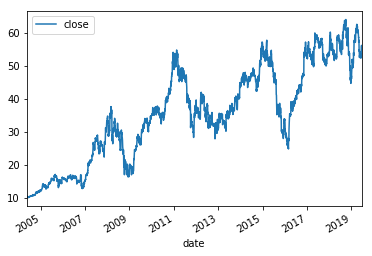

In [44]:
df.plot(x = 'date', y = 'close')

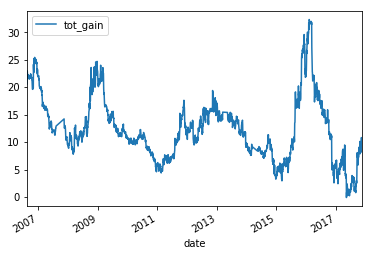

In [45]:
df_pruned.plot(x = 'date', y = 'tot_gain')

In [46]:
df

,date,close,eps,div,dy,pe,avg_50,avg_200,cap_gain,tot_gain
0,2004-05-18,10.080000,NaN,NaN,NaN,NaN,10.294799,10.279167,11.882253,NaN
1,2004-05-19,10.200000,NaN,NaN,NaN,NaN,10.298342,10.280105,11.796811,NaN
2,2004-05-20,10.230000,NaN,NaN,NaN,NaN,10.301465,10.281137,11.777310,NaN
3,2004-05-21,10.300000,NaN,NaN,NaN,NaN,10.304033,10.282266,11.729043,NaN
4,2004-05-25,10.450000,NaN,NaN,NaN,NaN,10.305887,10.283498,11.630910,NaN
5,2004-05-26,10.330000,NaN,NaN,NaN,NaN,10.306853,10.284837,11.718736,NaN
6,2004-05-27,10.350000,NaN,NaN,NaN,NaN,10.306745,10.286288,11.706644,NaN
7,2004-05-28,10.300000,NaN,NaN,NaN,NaN,10.305366,10.287855,11.744809,NaN
8,2004-05-31,10.300000,NaN,NaN,NaN,NaN,10.302523,10.289544,11.751579,NaN
9,2004-06-01,10.300000,NaN,NaN,NaN,NaN,10.298043,10.291358,11.753837,NaN


In [29]:
df['tot_gain'].std()

KeyError: 'tot_gain'

### Test PE Regression

In [31]:
#Code from predict_from_regression()

#Today's metrics
dy_today, pe_today, price_today = get_todays_metrics(df, divs)

#outfile.write('Gain\n')

#Prune to avoid nonsensical returns
valid_data_length = df.shape[0] - 400
df_pruned = prune_data(df[:valid_data_length], divs, 3.0)

##
## PE Prediction
##
X2 = pd.DataFrame(df_pruned['pe'])
y = pd.DataFrame(df_pruned['tot_gain'])

X2.fillna(value = 0, inplace = True)
y.fillna(value = 0, inplace = True)

model = LinearRegression()
model.fit(X2,y)
pred_val = model.predict(pe_today)
y_pred = model.predict(X2)

plt.scatter(X2, y,  color='red')
plt.plot(X2, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

print('Today\'s prediction: ' + str(pred_val))

score = model.score(X2, y)

print('DY R_squared: ' + str(score))


KeyError: 'tot_gain'

### Test DY Regression

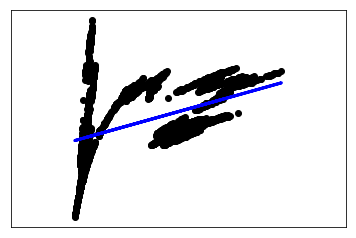

Today's prediction: [[21.04976261]]
DY R_squared: 0.20409541782567586


In [15]:
##
## DY Prediction
##


X = pd.DataFrame(df_pruned['dy'])
y = pd.DataFrame(df_pruned['tot_gain'])

X.fillna(value = 0, inplace = True)
y.fillna(value = 0, inplace = True)

model2 = LinearRegression()
model2.fit(X,y)

pred_val = model2.predict(dy_today)
y_pred = model2.predict(X)

plt.scatter(X, y,  color='black')
plt.plot(X, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

print('Today\'s prediction: ' + str(pred_val))


score = model2.score(X, y)

print('DY R_squared: ' + str(score))



### Test Multiple Regression

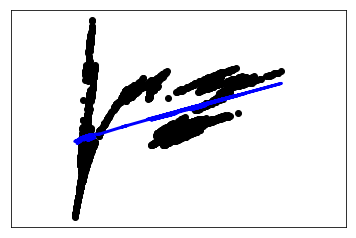

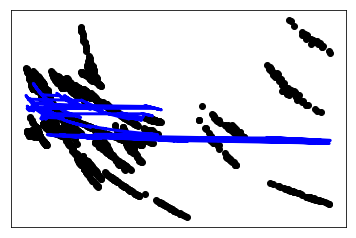

Today's prediction: [[20.92903899]]
Multiple R_squared: 0.20492385763958298


In [16]:
##
## Multiple Regression
##

X1 = pd.DataFrame(df_pruned[['pe', 'dy']])
y = pd.DataFrame(df_pruned['tot_gain'])

X1.fillna(value = 0, inplace = True)
y.fillna(value = 0, inplace = True)

model3 = LinearRegression()
model3.fit(X1,y)

pred_val = model3.predict(np.array([pe_today,dy_today]).reshape(1, -1))

y_pred = model3.predict(X1)

plt.scatter(X, y,  color='black')

plt.plot(X, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

plt.scatter(X2, y,  color='black')

plt.plot(X2, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()


print('Today\'s prediction: ' + str(pred_val))

score = model3.score(X1, y)

print('Multiple R_squared: ' + str(score))

In [ ]:
'''
advfn.db - uses google notation
tmx.db - uses google notation
yahoo.db 
    aav_prices uses yahoo notation
    divs uses yahoo notation
    splits uses yahoo notation
    tsx_prices uses google notation
    yahoo_indicators uses yahoo notation

'''

def main():

    sql_symbols = 'SELECT company_ticker FROM tsx_companies'
    advfn_curs.execute(sql_symbols)    
    symbols = advfn_curs.fetchall()
    #symbols are now in Google notation

    for sym in symbols:
        symbol = sym[0]
        print('Evaluate: ' + symbol)
        df, divs = market_df(symbol)

        #print(df)

        df['avg_50'] = custom_kernel(df['close'], kern_50)
        df['avg_200'] = custom_kernel(df['close'], kern_200)

        today = datetime.today()
        last_close = df['avg_200'][df.shape[0] -1]
        #print(df['avg_200'][df.shape[0] -1])

        #print('Elapsed: ' + str((today - df.head(1)['date_parsed'][0]).days / 365.25 ) + ' years')

        df['cap_gain'] = df.apply(lambda x: return_to_date(x, today, last_close), axis = 1) 
        if divs:
            #divs = True
            #print('Found a dividend yield')
            df['tot_gain'] = df['cap_gain'] + (df['div'] * 100)
        else:
            #divs = False
            #print('No dividend yield found')
            df['tot_gain'] = df['cap_gain']

        #print('  complete!')

        #Today's metrics
        dy_today, pe_today, price_today = get_todays_metrics(df, divs)

        if df.shape[0] > 400:
            predict_from_regression(df, divs, symbol)
            show_metrics_distribution(df, divs, symbol)
            advfn_database.commit()  
        else:
            print(symbol + ' has too few data samples (' + str(df.shape[0]) + ').')

    #outfile.close()

    advfn_database.close()

#if __name__ == '__main__':
#    main()

In [26]:
import pandas as pd
import numpy as np
import sqlite3
from sqlite3 import Error
from datetime import datetime
#%matplotlib inline

tmx_file = '/home/ian/Data/tmx.db'
yahoo_file = '/home/ian/Data/yahoo.db'
advfn_file = '/home/ian/Data/advfn.db'

tmx_conn = sqlite3.connect(tmx_file)
yahoo_conn = sqlite3.connect(yahoo_file)
advfn_conn = sqlite3.connect(advfn_file)

#def market_df(symbol):


reits = ['CHP.UN', 'AP.UN' , 'AFN', 'AX.UN', 'BEI.UN', 'CAR.UN', 'CRR.UN', 'CUF.UN', 'D.UN', 'DRG.UN', 'EXE', 'GRT.UN', 'HR.UN', 'IIP.UN', 'KMP.UN', 'NVU.UN', 'REI.UN', 'SRU.UN']

#tmx.db
    #tmx_earnings - uses '.', not split-adjusted
        #<symbol, date, eps>

#yahoo.db
    #tsx_prices - uses '.'
        #<symbol, Date, Close>
    #splits - uses '-'
        #<symbol, date, total_adjustment>
    #divs - split-adjusted, uses '-''
        #<symbol, Date, Dividends>
    #yahoo_indicators - split-adjusted, uses '-'
        #<symbol, Date, eps, div_payout>
    #aav_prices - uses '-'
        #<symbol, Date, Close

#advfn - no source data, contains company metatdata and currently where regression metrics are written to

symbol = 'AFN'

symbol_yahoo = symbol.replace('.','-') #'BNS'
symbol_google = symbol.replace('-','.') #'BNS'

tmx_sql = 'SELECT date, eps FROM tmx_earnings WHERE symbol = "{0}"'
df_tmx = pd.read_sql(tmx_sql.format(symbol_google), tmx_conn, parse_dates = {'date' : '%Y-%m-%d'})
df_tmx.columns = ['date', 'eps_raw']

tsx_prices_sql = 'SELECT Date, Close FROM tsx_prices WHERE symbol = "{0}"'
df_tsx_prices = pd.read_sql(tsx_prices_sql.format(symbol_google), yahoo_conn, parse_dates = {'Date' : '%Y-%m-%d'})
df_tsx_prices.columns = ['date' , 'close']

splits_sql = 'SELECT date, total_adjustment FROM splits WHERE symbol = "{0}"'
df_splits = pd.read_sql(splits_sql.format(symbol_yahoo), yahoo_conn, parse_dates = {'date' : '%Y-%m-%d'})

divs_sql = 'SELECT Date, Dividends FROM divs WHERE symbol = "{0}"'
df_divs = pd.read_sql(divs_sql.format(symbol_yahoo), yahoo_conn, parse_dates = {'Date' : '%Y-%m-%d'})
df_divs.columns = ['date', 'div_raw']

divs = (df_divs.shape[0] != 0)        

yahoo_indicators_sql = 'SELECT Date, eps, div_payout FROM yahoo_indicators WHERE symbol = "{0}"'
df_yahoo = pd.read_sql(yahoo_indicators_sql.format(symbol_yahoo), yahoo_conn, parse_dates ={'Date' : '%Y-%m-%d'})
df_yahoo.columns = ['date', 'eps', 'div']

aav_sql = 'SELECT Date, Close FROM aav_prices WHERE symbol = "{0}"'
df_aav = pd.read_sql(aav_sql.format(symbol_yahoo), yahoo_conn, parse_dates ={'Date' : '%Y-%m-%d'})
df_aav.columns = ['date', 'close'] 

df_price = pd.concat([df_tsx_prices[df_tsx_prices['close'].notnull()][['date', 'close']], df_aav[df_aav['close'].notnull()][['date','close']]])
print('Before merge: ' + str(df_price.shape))
df_price.drop_duplicates(subset ="date", inplace = True) 
print('After merge: ' + str(df_price.shape))

df_fix_tmx = df_tmx.join(df_splits.set_index('date'), on = 'date', how = 'outer', sort = True)
#df_fix_tmx['total_adjustment'].fillna(method='ffill', inplace = True)
df_fix_tmx['total_adjustment'].fillna(method='bfill', inplace = True)
df_fix_tmx['total_adjustment'].fillna(1, inplace = True)    
df_fix_tmx['eps'] = 4.0 * df_fix_tmx['eps_raw']# / df_fix_tmx['total_adjustment']
df_fix_tmx.dropna(inplace = True)

#df_fix_tmx.plot(x = 'date', y = 'eps')

df_fix_tmx.drop(['eps_raw', 'total_adjustment'], axis = 1, inplace = True)


df_eps = pd.concat([df_fix_tmx, df_yahoo[df_yahoo['eps'].notnull()][['date', 'eps']]])
df_eps = df_eps[df_eps['eps'] != 0]
df_eps.drop_duplicates(subset ="date", inplace = True)
df_eps.sort_values(by = 'date', inplace = True)

if divs:
    df_div = df_divs.copy().join(df_splits.set_index('date'), on = 'date', how = 'outer', sort = True)

    df_div['total_adjustment'].fillna(method='bfill', inplace = True)
    df_div['total_adjustment'].fillna(1, inplace = True)

    if symbol_google in reits:
        df_div['div'] = df_div['div_raw'] * 12.0 / df_div['total_adjustment']
    else:
        df_div['div'] = df_div['div_raw'] * 4.0 / df_div['total_adjustment']

    df_div.dropna(inplace = True)

    df_div.drop(['div_raw', 'total_adjustment'], axis = 1, inplace = True)

    df_div = pd.concat([df_div, df_yahoo[['date', 'div']]])

df_eps.drop_duplicates(subset ="date", inplace = True)

if divs:
    df_div.sort_values(by = 'date', inplace = True)

df = df_price.join(df_eps.set_index('date'), on = 'date', how = 'outer', sort = True)
df['eps'].fillna(method = 'ffill', inplace = True)

if divs:
    df = df.join(df_div.set_index('date'), on = 'date', how = 'outer', sort = True)
    df['div'].fillna(method = 'ffill', inplace = True)

    df['dy'] = df['div'] / df['close']

df['close'].replace(0, np.NaN, inplace=True)
#df['close'].interpolate(inplace = True)
#df.dropna(inplace = True)

df['pe'] = df['close'] / df['eps']

    
ret = df[df['close'].notnull()].copy()

ret = ret.reset_index(drop = True)

#return ret, divs



Before merge: (3788, 2)
After merge: (3788, 2)


In [27]:
df

,date,close,eps,pe
0,2004-05-18,10.080000,NaN,NaN
1,2004-05-19,10.200000,NaN,NaN
2,2004-05-20,10.230000,NaN,NaN
3,2004-05-21,10.300000,NaN,NaN
4,2004-05-25,10.450000,NaN,NaN
5,2004-05-26,10.330000,NaN,NaN
6,2004-05-27,10.350000,NaN,NaN
7,2004-05-28,10.300000,NaN,NaN
8,2004-05-31,10.300000,NaN,NaN
9,2004-06-01,10.300000,NaN,NaN
